In [ ]:
!pip install fastai -U

In [ ]:
pip install dtreeviz

In [ ]:
pip install nbdev

In [163]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import display

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [1]:
#Acquiring dataset from Kaggle
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pip install kaggle --upgrade
!ls -l /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c bluebook-for-bulldozers

 85% 41.0M/48.4M [00:00<00:00, 50.0MB/s]
100% 48.4M/48.4M [00:00<00:00, 89.7MB/s]


In [ ]:
!unzip /content/bluebook-for-bulldozers.zip

In [246]:
path = '/content/TrainAndValid.csv'

In [247]:
## Taking a look at the dataset 

df = pd.read_csv(path, low_memory=False)
df.head()

,SalesID,SalePrice,MachineID,ModelID,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,...,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,...,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,...,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,...,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,...,NaN,NaN,NaN,NaN


In [248]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [249]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [250]:
sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'

In [ ]:
df['ProductSize'][:20]

In [251]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [252]:
## Using Root Mean Square Log Error (RMSLE) as the metric
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

In [253]:
df = add_datepart(df, 'saledate')

In [254]:
df_test = pd.read_csv("/content/Test.csv", low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [255]:
" ".join(i for i in df_test.columns if i.startswith('sale'))

'saleWeek saleYear saleMonth saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [256]:
## Using TabularPandas and TabularProc for some data cleaning
# Categorify replaces columns with numerical categorical column
# FillMissing replaces missing values with the median value of the column and
# creates a new Boolean column that is set to true for row where val was missing
procs = [Categorify, FillMissing]

In [257]:
## Getting the validations set
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))


In [258]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [259]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [260]:
len(to.train), len(to.valid)

(404710, 7988)

In [261]:
# Data is still displayed as string
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,saleWeek,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1163635200,False,False,1139246,999089,46,3157,121,3.0,2004,68.0,2006,11,16,3,320,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1080259200,False,False,1139248,117657,13,77,121,3.0,1996,4640.0,2004,3,26,4,86,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,1077753600,False,False,1139249,434808,9,7009,121,3.0,2001,2838.0,2004,2,26,3,57,9.210340


In [262]:
# Just looking at a few columns
to1 = TabularPandas(df, procs, cat_names=['state', 'ProductGroup', 'Drive_System', 'Enclosure'],
                    y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


In [263]:
to.items.head(3)

,SalesID,SalePrice,MachineID,saleWeek,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,46,...,1,2647,1,1
1,1139248,10.950807,117657,13,...,1,2148,1,1
2,1139249,9.210340,434808,9,...,1,2131,1,1


In [264]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [265]:
to.classes['ProductSize']

(#7) ['#na#','Large','Large / Medium','Medium','Small','Mini','Compact']

In [139]:
(path / 'to.pkl').save(to)

In [266]:
##Splitting the data into training and validation prior to training
xs,y = to.train.xs, to.train.y
valid_xs,valid_y = to.valid.xs, to.valid.y

In [269]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

In [267]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs,y);

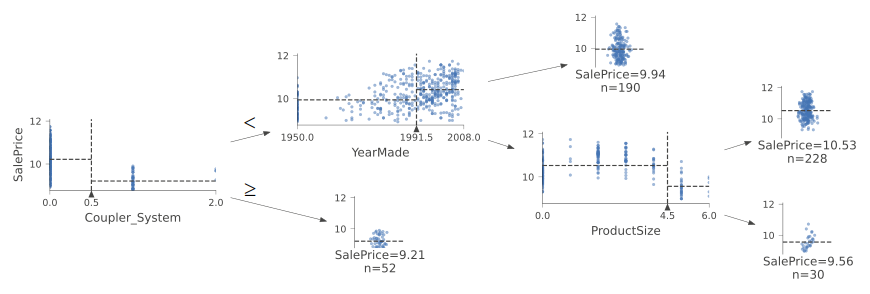

In [270]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [272]:
## Using a bigger tree
# This tree has no length stop criteria
m = DecisionTreeRegressor()
m.fit(xs, y);

In [ ]:
def r_mse(pred,y): return round(math.sqrt(((pred - y)**2).mean()), 4)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [273]:
m_rmse(m, xs, y)

0.0

In [274]:
## Model is perfect 
##Let's check with the validation data
m_rmse(m, valid_xs, valid_y)

0.3325

In [275]:
## Lot of leaves. Signs of overfitting
m.get_n_leaves(), len(xs)

(324542, 404710)

In [276]:
## Using stopping criteria of min leaves length 25
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, to.train.xs, to.train.y), m_rmse(m, to.valid.xs, to.valid.y)

(0.2117, 0.2681)

In [277]:
m.get_n_leaves()

12397

In [280]:
## Creating Random Forest
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                                 max_samples=max_samples, max_features=max_features,
                                 min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs,y)

In [281]:
m = rf(xs,y)

In [284]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.1713, 0.2337)

In [285]:
## Getting predictions from each tree
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [286]:
r_mse(preds.mean(0), valid_y)

0.2337

In [287]:
## Plotting the predictions of the trees
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in ])